## Reproducible Deep Learning (PhD course, Data Science)
### Lecture 1: deep learning recap

We will code a simple audio classification model (a convolutional neural network) for the ESC-50 dataset: https://github.com/karolpiczak/ESC-50. The aim is to recap some deep learning concepts, and have a working notebook to use as starting point for the next exercises.

**Setup the machine**:
1. Follow the instructions from here: https://github.com/sscardapane/reprodl2021#local-set-up
2. Download the ESC-50 dataset inside a 'data' folder.

In [1]:
import torch, torchaudio
from torch import nn
from torch.nn import functional as F

C:\Users\Maverick\Anaconda3\envs\reprodl\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
torch.cuda.is_available()

True

### Step 1: Some experiments in audio loading and transformation

The code in this section is just for experimentation, and will be removed when porting to a script.

In [5]:
# Substitute this with your actual path. This is the root folder of ESC-50, where
# you can find the subfolders 'audio' and 'meta'.
datapath = Path('data/ESC-50')

In [6]:
datapath.exists()

True

In [7]:
# Using Path is fundamental to have reproducible code across different operating systems.
csv = pd.read_csv(datapath / Path('meta/esc50.csv'))

In [8]:
# We need only filename, fold, and target
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [9]:
# We can use torchaudio.load to load the file. The second value is the sampling rate of the file.
x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0, 0], normalize=True)

In [10]:
x.shape

torch.Size([1, 220500])

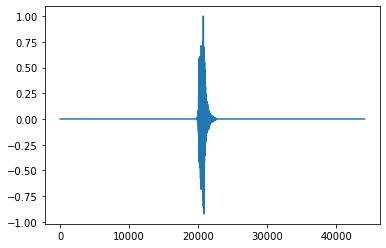

In [11]:
plt.plot(x[0, ::5])

In [12]:
# Useful transformation to resample the original file.
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

In [13]:
# Another useful transformation to build a Mel spectrogram (image-like), so that
# we can apply any CNN on top of it.
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

C:\Users\Maverick\Anaconda3\envs\reprodl\lib\site-packages\torchaudio\functional\functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [14]:
h.shape

torch.Size([1, 128, 1103])

In [15]:
# Convert to DB magnitude, useful for scaling.
# Note: values could be further normalize to significantly speed-up and simplify training.
h = torchaudio.transforms.AmplitudeToDB()(h)

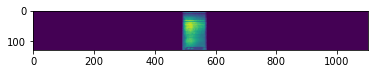

In [16]:
plt.imshow(h[0])

### Step 2: Putting together data loading and preprocessing

In [17]:
class ESC50Dataset(torch.utils.data.Dataset):
    # Simple class to load the desired folders inside ESC-50
    
    def __init__(self, path: Path = Path('data/ESC-50'), 
                 sample_rate: int = 8000,
                 folds = [1]):
        # Load CSV & initialize all torchaudio.transforms:
        # Resample --> MelSpectrogram --> AmplitudeToDB
        self.path = path
        self.csv = pd.read_csv(path / Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)]
        self.resample = torchaudio.transforms.Resample(
            orig_freq=44100, new_freq=sample_rate
        )
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        
        
    def __getitem__(self, index):
        # Returns (xb, yb) pair, after applying all transformations on the audio file.
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename'])
        label = row['target']
        xb = self.db(
            self.melspec(
                self.resample(wav)
            )
        )
        return xb, label
        
    def __len__(self):
        # Returns length
        return len(self.csv)

In [18]:
train_data = ESC50Dataset()

In [19]:
for xb, yb in train_data:
    break

In [20]:
xb.shape

torch.Size([1, 128, 201])

In [21]:
yb

0

### Step 3: Build a classification model

In [22]:
# We use folds 1,2,3 for training, 4 for validation, 5 for testing.
train_data = ESC50Dataset(folds=[1,2,3])
val_data = ESC50Dataset(folds=[4])
test_data = ESC50Dataset(folds=[5])

In [23]:
train_loader = \
    torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

In [24]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [25]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [32]:
class AudioNet(pl.LightningModule):
    
    def __init__(self, n_classes = 50, base_filters = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # Very simple training loop
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc
    
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('test_acc', acc, on_epoch=True)
        return acc
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [33]:
pl.seed_everything(0)

Global seed set to 0


0

In [34]:
# Test that the network works on a single mini-batch
audionet = AudioNet()
xb, yb = next(iter(train_loader))
audionet(xb).shape

torch.Size([8, 50])

In [36]:
trainer = pl.Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [37]:
trainer.fit(audionet, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 3.9 K 
1  | bn1   | BatchNorm2d | 64    
2  | conv2 | Conv2d      | 9.2 K 
3  | bn2   | BatchNorm2d | 64    
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 18.5 K
6  | bn3   | BatchNorm2d | 128   
7  | conv4 | Conv2d      | 73.9 K
8  | bn4   | BatchNorm2d | 256   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 6.5 K 
---------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.450     Total estimated model params size (MB)


Global seed set to 0


Epoch 0:  75%|███████████████████████████         | 150/200 [00:20<00:06,  7.42it/s, loss=3.51, v_num=1, val_acc=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████████████████████████         | 150/200 [00:20<00:06,  7.25it/s, loss=3.28, v_num=1, val_acc=0.112]
Validating: 0it [00:00, ?it/s]
Epoch 1:  82%|█████████████████████████████▋      | 165/200 [00:22<00:04,  7.36it/s, loss=3.28, v_num=1, val_acc=0.112]


Epoch 2:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.67it/s, loss=3.27, v_num=1, val_acc=0.142]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|████████████████████████████████▍   | 180/200 [00:22<00:02,  7.86it/s, loss=3.27, v_num=1, val_acc=0.142]


Epoch 3:  75%|██████████████████████████▎        | 150/200 [00:19<00:06,  7.72it/s, loss=3.08, v_num=1, val_acc=0.0975]
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|██████████████████████████████████▏| 195/200 [00:24<00:00,  7.91it/s, loss=3.08, v_num=1, val_acc=0.0975]


Epoch 4:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.70it/s, loss=2.82, v_num=1, val_acc=0.257]
Validating: 0it [00:00, ?it/s]
Epoch 5:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.81it/s, loss=2.84, v_num=1, val_acc=0.255]
Validating: 0it [00:00, ?it/s]
Validating:  14%|█████████▉                                                             | 7/50 [00:00<00:05,  8.31it/s]


Epoch 6:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.67it/s, loss=2.71, v_num=1, val_acc=0.183]
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|███████████████████████████████▎    | 174/200 [00:22<00:03,  7.78it/s, loss=2.71, v_num=1, val_acc=0.183]


Epoch 7:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.58it/s, loss=2.72, v_num=1, val_acc=0.278]
Validating: 0it [00:00, ?it/s]
Validating:  74%|███████████████████████████████████████████████████▊                  | 37/50 [00:04<00:01,  8.91it/s]


Epoch 8:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.67it/s, loss=2.52, v_num=1, val_acc=0.303]
Validating: 0it [00:00, ?it/s]
Epoch 9:  75%|███████████████████████████         | 150/200 [00:19<00:06,  7.71it/s, loss=2.48, v_num=1, val_acc=0.245]
Validating: 0it [00:00, ?it/s]
Validating:   8%|█████▋                                                                 | 4/50 [00:00<00:05,  8.46it/s]


Epoch 9: 100%|████████████████████████████████████| 200/200 [00:25<00:00,  7.91it/s, loss=2.48, v_num=1, val_acc=0.325]


In [38]:
# TODO: implement the test loop.
trainer.test(audionet, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.18it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3100000023841858}
--------------------------------------------------------------------------------


[{'test_acc': 0.3100000023841858}]